In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  3 10:33:00 2021

@author: jamesmason
"""
from ClassFiles.ShapeGenerator import ShapeGenerator
from ClassFiles.ChanVese import ChanVese


from PIL import Image
import datetime
import numpy as np

def create(times=1,size=(128, 128), cleansaave     ="images/clean/clean_", 
                                    dirtysave      ="images/dirty/dirty_",
                                    chansave       ="images/chan-vese/chanvese_",
                                    datacleansaave ="data/clean/clean_", 
                                    datadirtysave  ="data/dirty/dirty_",
                                    datachansave   ="data/chan-vese/chanvese_"):
    
    for i in range(times):
        e = datetime.datetime.now().strftime("%m_%d_%H_%M_%S_%f")
        #create a clean image
        shapes = ShapeGenerator(128, 128)
        shapes.add_polygon(times=3)
        shapes.add_ellipse(times=3)
        #save in clean
        shapes.image.save(fp = cleansaave+e+".png", format = 'PNG')
        np.save(file = datacleansaave+e , arr = np.array(shapes.image)/255)
        #add noise
        shapes.add_holes(40)
        shapes.add_noise()
        #save in dirty 
        shapes.image.save(fp = dirtysave+e+".png", format = 'PNG')
        np.save(file = datadirtysave+e , arr = np.array(shapes.image)/255)
        #apply chan-vese
        shapes = ChanVese(shapes.image)
        shapes.run(steps = 400,show_iterations=False)
        #save in chan-vese
        np.save(file = datachansave+e , arr = shapes.u)
        im = Image.fromarray(255*shapes.u).convert("L")
        im.save(fp =  chansave+e+".png", format = 'PNG')

In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  3 10:33:00 2021

@author: jamesmason
"""
from ClassFiles.ShapeGenerator import ShapeGenerator
from ClassFiles.ChanVese import ChanVese


from PIL import Image
import datetime
import numpy as np

def create(times=1,size=(128, 128), cleansaave     ="eval/images/clean/clean_", 
                                    dirtysave      ="eval/images/dirty/dirty_",
                                    chansave       ="eval/images/chan-vese/chanvese_",
                                    datacleansaave ="eval/data/clean/clean_", 
                                    datadirtysave  ="eval/data/dirty/dirty_",
                                    datachansave   ="eval/data/chan-vese/chanvese_"):
    
    for i in range(times):
        e = datetime.datetime.now().strftime("%m_%d_%H_%M_%S_%f")
        #create a clean image
        shapes = ShapeGenerator(128, 128)
        shapes.add_polygon(times=3)
        shapes.add_ellipse(times=3)
        #save in clean
        shapes.image.save(fp = cleansaave+e+".png", format = 'PNG')
        np.save(file = datacleansaave+e , arr = np.array(shapes.image)/255)
        #add noise
        shapes.add_holes(40)
        shapes.add_noise()
        #save in dirty 
        shapes.image.save(fp = dirtysave+e+".png", format = 'PNG')
        np.save(file = datadirtysave+e , arr = np.array(shapes.image)/255)
        #apply chan-vese
        shapes = ChanVese(shapes.image)
        shapes.run(steps = 400,show_iterations=False)
        #save in chan-vese
        np.save(file = datachansave+e , arr = shapes.u)
        im = Image.fromarray(255*shapes.u).convert("L")
        im.save(fp =  chansave+e+".png", format = 'PNG')

In [17]:
create(100)

In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from ClassFiles.DataLoader import get_generated_dataloader

""" for now we assume we generate all training data beforehand as numpy arrays.
we then convert to pytorch tensors and store on the cpu memory, converting to
gpu memory when needed. If memory or speed becomes an issue we could rewrite the
training data generation on the gpu using pytorch's linear algebra, and generate
it in situ while training """



def train(
    NN,
    epochs=100,
    batch_size=20,
    mu=20,
    lr=0.0001,
    device="cuda:0" if torch.cuda.is_available() else "cpu",
):
    """
    NN is the neural network, e.g. could initialise by NN = SebastianConvNet(1, 256, 256)

    groundtruth_numpy is numpy array of [batchsize, image_channels,
    image_height, image_width] groundtruth segmentations

    chanvese_numpy is numpy array of [batchsize, image_channels, image_height,
    image_width] chanvese segmentations

    The two datasets do not have to contain corresponding images for the purpose
    of training (see paper for why) INFACT THEY SHOULDN'T (should probably
    incorporate this by shuffling beforehand, or could potentially include a
    shuffle command here)

    """

    NN.to(device)
    # not sure why Sebastian doesn't use Adam, but hey
    optimiser = optim.RMSprop(NN.parameters(), lr=lr)
    
    
    groundtruth_loader = get_generated_dataloader('train', 'clean', batch_size)
    chanvese_loader = get_generated_dataloader('train', 'chan-vese', batch_size)

    for i in range(epochs):
        """
        haven't got a log keeping track of training progress at the moment
        """
        
        
        assert len(groundtruth_loader) == len(chanvese_loader)
        
        groundtruth_iter = iter(groundtruth_loader)
        chanvese_iter = iter(chanvese_loader)
        
        for i in range(len(groundtruth_loader)):
            groundtruth_batch = groundtruth_iter.next()[0]
            chanvese_batch = chanvese_iter.next()[0]
            
            assert groundtruth_batch.size() == chanvese_batch.size()

            groundtruth_batch = groundtruth_batch.to(device)
            chanvese_batch = chanvese_batch.to(device)

            batchsize = groundtruth_batch.size(0)

            # REVIEW: Unsqueezing over the 1-axis is enough for batchwise multiplication
            epsilon = torch.rand([batchsize], device=device).unsqueeze(1).unsqueeze(2).unsqueeze(3)

            intermediate_batch = (
                epsilon * groundtruth_batch + (1 - epsilon) * chanvese_batch
            )  # [batchsize, channels, height, width]
            intermediate_batch.requires_grad = True

            # apply the neural network
            groundtruth_out = NN(groundtruth_batch)  # [batchsize]
            chanvese_out = NN(chanvese_batch)  # [batchsize]
            intermediate_out = NN(intermediate_batch)  # [batchsize]

            # REVIEW: Why mean() and not sum()?
            # calculate the loss
            wasserstein_loss = (groundtruth_out - chanvese_out).mean()  # [1]

            # Set 'create_graph=True' so we can backprop a function of the
            # gradient (--> second derivatives). This is needed for implementing
            # the approximate 1-Lipschitz constraint.
            # REVIEW: Maybe we should use "retain_graph"?
            gradient = torch.autograd.grad(
                intermediate_out.sum(), intermediate_batch, create_graph=True
            )[0]
            # --> [batchsize, channels, height, width]

            gradient_loss = (
                (F.relu(gradient.square().sum((1, 2, 3)).sqrt() - 1)).square().mean()
            )  # [1]
            loss = wasserstein_loss + mu * gradient_loss  # [1]

            # backprop step
            # no need to zero the gradients of the intermediate point, since it
            # is reinitialised each batch
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
        
        print('done epoch')
    
    torch.save(NN.state_dict(), 'shapesNN_trained')

    return NN.to("cpu")

In [23]:
from ClassFiles.networks import SebastianConvNet
NN = SebastianConvNet(1, 128, 128)

In [28]:
NN_trained = train(NN)

done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch
done epoch

In [31]:
eval_groundtruth_loader = get_generated_dataloader('eval', 'clean', batch_size = 20)
eval_chanvese_loader = get_generated_dataloader('eval', 'chan-vese', batch_size = 20)

In [40]:
eval_groundtruth_batch = iter(eval_groundtruth_loader).next()[0]
eval_chanvese_batch = iter(eval_chanvese_loader).next()[0]

In [37]:
print(NN_trained(eval_groundtruth_batch).mean().item(), NN_trained(eval_chanvese_batch).mean().item())

-45.81377410888672 -38.07417678833008


In [39]:
print(NN_trained(eval_groundtruth_batch).mean().item(), NN_trained(eval_chanvese_batch).mean().item())

-45.640769958496094 -31.28079605102539


In [41]:
print(NN_trained(eval_groundtruth_batch).mean().item(), NN_trained(eval_chanvese_batch).mean().item())

-48.58849334716797 -30.307575225830078


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from ClassFiles.DataLoader import get_generated_dataloader

""" for now we assume we generate all training data beforehand as numpy arrays.
we then convert to pytorch tensors and store on the cpu memory, converting to
gpu memory when needed. If memory or speed becomes an issue we could rewrite the
training data generation on the gpu using pytorch's linear algebra, and generate
it in situ while training """



def train(
    NN,
    epochs=100,
    batch_size=20,
    mu=20,
    lr=0.0001,
    device="cuda:0" if torch.cuda.is_available() else "cpu",
):
    """
    NN is the neural network, e.g. could initialise by NN = SebastianConvNet(1, 256, 256)

    groundtruth_numpy is numpy array of [batchsize, image_channels,
    image_height, image_width] groundtruth segmentations

    chanvese_numpy is numpy array of [batchsize, image_channels, image_height,
    image_width] chanvese segmentations

    The two datasets do not have to contain corresponding images for the purpose
    of training (see paper for why) INFACT THEY SHOULDN'T (should probably
    incorporate this by shuffling beforehand, or could potentially include a
    shuffle command here)

    """

    NN.to(device)
    # not sure why Sebastian doesn't use Adam, but hey
    optimiser = optim.RMSprop(NN.parameters(), lr=lr)
    
    
    groundtruth_loader = get_generated_dataloader('train', 'clean', batch_size)
    chanvese_loader = get_generated_dataloader('train', 'chan-vese', batch_size)
    
    eval_groundtruth_loader = get_generated_dataloader('eval', 'clean', batch_size = 100)
    eval_chanvese_loader = get_generated_dataloader('eval', 'chan-vese', batch_size = 100)
    
    
    eval_groundtruth_batch = iter(eval_groundtruth_loader).next()[0].to(device)
    eval_chanvese_batch = iter(eval_chanvese_loader).next()[0].to(device)
    with torch.no_grad():
        groundtruth_mean_value = NN(eval_groundtruth_batch).mean().item()
        chanvese_mean_value = NN(eval_chanvese_batch).mean().item()
    print('untrained performance', groundtruth_mean_value, chanvese_mean_value)
    
    for i in range(epochs):
        """
        haven't got a log keeping track of training progress at the moment
        """
        
        
        assert len(groundtruth_loader) == len(chanvese_loader)
        
        groundtruth_iter = iter(groundtruth_loader)
        chanvese_iter = iter(chanvese_loader)
        
        for i in range(len(groundtruth_loader)):
            groundtruth_batch = groundtruth_iter.next()[0]
            chanvese_batch = chanvese_iter.next()[0]
            
            assert groundtruth_batch.size() == chanvese_batch.size()

            groundtruth_batch = groundtruth_batch.to(device)
            chanvese_batch = chanvese_batch.to(device)

            batchsize = groundtruth_batch.size(0)

            # REVIEW: Unsqueezing over the 1-axis is enough for batchwise multiplication
            epsilon = torch.rand([batchsize], device=device).unsqueeze(1).unsqueeze(2).unsqueeze(3)

            intermediate_batch = (
                epsilon * groundtruth_batch + (1 - epsilon) * chanvese_batch
            )  # [batchsize, channels, height, width]
            intermediate_batch.requires_grad = True

            # apply the neural network
            groundtruth_out = NN(groundtruth_batch)  # [batchsize]
            chanvese_out = NN(chanvese_batch)  # [batchsize]
            intermediate_out = NN(intermediate_batch)  # [batchsize]

            # REVIEW: Why mean() and not sum()?
            # calculate the loss
            wasserstein_loss = (groundtruth_out - chanvese_out).mean()  # [1]

            # Set 'create_graph=True' so we can backprop a function of the
            # gradient (--> second derivatives). This is needed for implementing
            # the approximate 1-Lipschitz constraint.
            # REVIEW: Maybe we should use "retain_graph"?
            gradient = torch.autograd.grad(
                intermediate_out.sum(), intermediate_batch, create_graph=True
            )[0]
            # --> [batchsize, channels, height, width]

            gradient_loss = (
                (F.relu(gradient.square().sum((1, 2, 3)).sqrt() - 1)).square().mean()
            )  # [1]
            loss = wasserstein_loss + mu * gradient_loss  # [1]

            # backprop step
            # no need to zero the gradients of the intermediate point, since it
            # is reinitialised each batch
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
        
        eval_groundtruth_batch = iter(eval_groundtruth_loader).next()[0].to(device)
        eval_chanvese_batch = iter(eval_chanvese_loader).next()[0].to(device)
        with torch.no_grad():
            groundtruth_mean_value = NN(eval_groundtruth_batch).mean().item()
            chanvese_mean_value = NN(eval_chanvese_batch).mean().item()
        print('done epoch', groundtruth_mean_value, chanvese_mean_value)
    
    torch.save(NN.state_dict(), 'shapesNN_trained2')

    return NN.to("cpu")

In [2]:
from ClassFiles.networks import SebastianConvNet
NN = SebastianConvNet(1, 128, 128)
NN_trained2 = train(NN)

untrained performance 0.03932619467377663 0.03931102901697159


KeyboardInterrupt: 

In [36]:
NN=SebastianConvNet(1, 128, 128)
NN.load_state_dict(torch.load("./shapesNN_trained", map_location=torch.device('cpu')))

<All keys matched successfully>

100%|██████████| 250/250 [00:28<00:00,  8.88it/s]


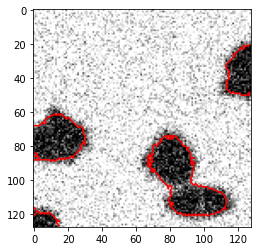

In [41]:
import ClassFiles.ChanVese as cv
from PIL import Image
import matplotlib.pyplot as plt

im = Image.open("./eval/images/dirty/dirty/dirty_03_06_11_16_10_237058.png")
cv_reconstruction = cv.ChanVese(im)
cv_reconstruction.run(250, show_iterations=True)
cv_reconstruction.show_segmentation()
#cv_reconstruction.run(300, show_iterations=True)
#cv_reconstruction.show_segmentation()

In [45]:
import ClassFiles.DeepSegmentation as ds
from ClassFiles.networks import SebastianConvNet
import torch

NN=SebastianConvNet(1, 128, 128)
NN.load_state_dict(torch.load("./shapesNN_trained", map_location=torch.device('cpu')))
ds_reconstruction = ds.DeepSegmentation(im, NN, u_init = cv_reconstruction.u)

100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


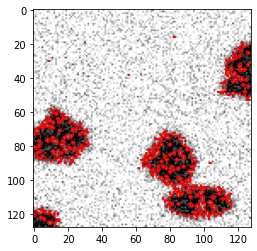

In [46]:
ds_reconstruction.run(100, show_iterations=True, lmb_reg=10)
ds_reconstruction.segmentation_threshold = 0.5
ds_reconstruction.show_segmentation()